In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_io as tfio
import matplotlib.pyplot as plt
from IPython import display
from jiwer import wer
import os
import nltk
import pickle
import textdistance
import re
import IPython.display

In [2]:
#load csv file and split into train, validation and test
metadata_path = 'metadata.csv'
wavs_path = 'audio_transcription/resampled_audio/'

metadata_df = pd.read_csv(metadata_path)
metadata_df.drop(columns=metadata_df.columns[0], axis=1, inplace=True)
metadata_df = metadata_df.sample(frac=1,random_state=0).reset_index(drop=True)

split1 = int(len(metadata_df) * 0.85) #85% training set
split2 = int(len(metadata_df) * 0.95) #10% validation set 5% test set
df_train = metadata_df[:split1]
df_val = metadata_df[split1:split2]
df_test = metadata_df[split2:]

# df_train = pd.read_csv('metadata_nonoise100%+timestretch100%_train.csv')
# df_train = df_train.sample(frac=1,random_state=0).reset_index(drop=True)

print(len(metadata_df))
print(f"Size of the training set: {len(df_train)}")
print(f"Size of the validation set: {len(df_val)}")
print(f"Size of the test set: {len(df_test)}")

df_train

23697
Size of the training set: 20142
Size of the validation set: 2370
Size of the test set: 1185


,wav_filename,transcript
0,resampled_audio_14440,air berlin eight four three nine
1,resampled_audio_25292,csa six three five runway three one clear to l...
2,resampled_audio_8178,hapag lloyd three five five one descend now to...
3,resampled_audio_4829,sunwing five two one two contact zurich one th...
4,resampled_audio_12516,eurotrans four eight zero
...,...,...
20137,resampled_audio_1473,alitalia three hundred bonjour squawk five sev...
20138,resampled_audio_23311,ehm skytravel six seven zero stand one
20139,resampled_audio_21084,wizzair five hundred descend flight level nine...
20140,resampled_audio_4518,fox romeo india


In [22]:
#to extract spectrogram
characters = [x for x in "abcdefghijklmnopqrstuvwxyz'. "]
char_to_num = keras.layers.StringLookup(vocabulary=characters,oov_token="")
num_to_char = keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True)

print(f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})")

# An integer scalar Tensor. The window length in samples.
frame_length = 256
# An integer scalar Tensor. The number of samples to step.
frame_step = 160
# An integer scalar Tensor. The size of the FFT to apply.
# If not provided, uses the smallest power of 2 enclosing frame_length.
fft_length = 384


def encode_single_sample(wav_file, label):
    ###########################################
    ##  Process the Audio
    ##########################################
    # 1. Read wav file
    file = tf.io.read_file(wavs_path + wav_file + ".wav")
    # 2. Decode the wav file
    audio, _ = tf.audio.decode_wav(file)
    audio = tf.squeeze(audio, axis=-1)
    # 3. Change type to float
    audio = tf.cast(audio, tf.float32)
    # 4. Get the spectrogram
    spectrogram = tf.signal.stft(
        audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length
    )
    # 5. We only need the magnitude, which can be derived by applying tf.abs
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.math.pow(spectrogram, 0.5)
    # 6. normalisation
    means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
    spectrogram = (spectrogram - means) / (stddevs + 1e-10)
    ###########################################
    ##  Process the label
    ##########################################
    # 7. Convert label to Lower case
    label = tf.strings.lower(label)
    # 8. Split the label
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")
    # 9. Map the characters in label to numbers
    label = char_to_num(label)
    # 10. Return a dict as our model is expecting two inputs
    return spectrogram, label

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '.', ' '] (size =30)


In [18]:
#to extract mfcc
characters = [x for x in "abcdefghijklmnopqrstuvwxyz'. "]
char_to_num = keras.layers.StringLookup(vocabulary=characters,oov_token="")
num_to_char = keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True)

print(f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})")


def encode_single_sample(wav_file, label):
    ###########################################
    ##  Process the Audio
    ##########################################
    # 1. Read wav file
    file = tf.io.read_file(wavs_path + wav_file + ".wav")
    # 2. Decode the wav file
    audio, _ = tf.audio.decode_wav(file)
    audio = tf.squeeze(audio, axis=-1)
    # 3. Change type to float
    audio = tf.cast(audio, tf.float32)
    # 4. Get the spectrogram
    spectrogram = tfio.audio.spectrogram(
        audio, nfft=384, window=256, stride=160)
    mel_spectrogram = tfio.audio.melscale(
    spectrogram, rate=22050, mels=193, fmin=0, fmax=8000)
    mel_spectrogram = tf.abs(mel_spectrogram)
    mel_spectrogram = tf.math.pow(mel_spectrogram, 0.5)
    # 6. normalisation
    means = tf.math.reduce_mean(mel_spectrogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(mel_spectrogram, 1, keepdims=True)
    mel_spectrogram = (mel_spectrogram - means) / (stddevs + 1e-10)
    ###########################################
    ##  Process the label
    ##########################################
    # 7. Convert label to Lower case
    label = tf.strings.lower(label)
    # 8. Split the label
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")
    # 9. Map the characters in label to numbers
    label = char_to_num(label)
    # 10. Return a dict as our model is expecting two inputs
    return mel_spectrogram, label

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '.', ' '] (size =30)


In [23]:
batch_size = 32
# Define the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_train["wav_filename"]), list(df_train["transcript"]))
)
train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Define the validation dataset
validation_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_val["wav_filename"]), list(df_val["transcript"]))
)
validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Define the test dataset
test_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_test["wav_filename"]), list(df_test["transcript"]))
)
test_dataset = (
    test_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

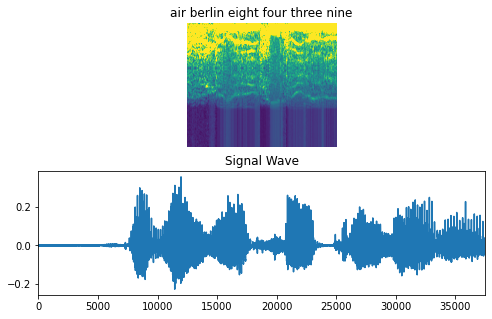

In [24]:
#visualise spectrogram/mfcc
fig = plt.figure(figsize=(8, 5))
for batch in train_dataset.take(1):
    spectrogram = batch[0][0].numpy()
    spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
    label = batch[1][0]
    # Spectrogram
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    ax = plt.subplot(2, 1, 1)
    ax.imshow(spectrogram, vmax=1)
    ax.set_title(label)
    ax.axis("off")
    # Wav
    file = tf.io.read_file(wavs_path + list(df_train["wav_filename"])[0] + ".wav")
    audio, _ = tf.audio.decode_wav(file)
    audio = audio.numpy()
    ax = plt.subplot(2, 1, 2)
    plt.plot(audio)
    ax.set_title("Signal Wave")
    ax.set_xlim(0, len(audio))
    display.display(display.Audio(np.transpose(audio), rate=22050))
    plt.show()

In [25]:
def CTCLoss(y_true, y_pred):
    # Compute the training-time loss value
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")
    print('input length:',input_length)
    print('label length:', label_length)
    
    input_length = (input_length+1) * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    
    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [26]:
def build_model(input_dim, output_dim, rnn_layers=5, rnn_units=128):
    """Model similar to DeepSpeech2."""
    # Model's input
    input_spectrogram = layers.Input((None, input_dim), name="input")
    # Expand the dimension to use 2D CNN.
    x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectrogram)
    # Convolution layer 1
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 41],
        strides=[2, 2],
        padding="same",
        use_bias=False,
        name="conv_1",
    )(x)
    x = layers.BatchNormalization(name="conv_1_bn")(x)
    x = layers.ReLU(name="conv_1_relu")(x)
    # Convolution layer 2
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 21],
        strides=[1, 2],
        padding="same",
        use_bias=False,
        name="conv_2",
    )(x)
    x = layers.BatchNormalization(name="conv_2_bn")(x)
    x = layers.ReLU(name="conv_2_relu")(x)
    # Reshape the resulted volume to feed the RNNs layers
    x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)
    # RNN layers
    for i in range(1, rnn_layers + 1):
        recurrent = layers.GRU(
            units=rnn_units,
            activation="tanh",
            recurrent_activation="sigmoid",
            use_bias=True,
            return_sequences=True,
            reset_after=True,
            name=f"gru_{i}",
        )
        x = layers.Bidirectional(
            recurrent, name=f"bidirectional_{i}", merge_mode="concat"
        )(x)
        if i < rnn_layers:
            x = layers.Dropout(rate=0.5)(x)
    # Dense layer
    x = layers.Dense(units=rnn_units * 2, name="dense_1")(x)
    x = layers.ReLU(name="dense_1_relu")(x)
    x = layers.Dropout(rate=0.5)(x)
    # Classification layer
    output = layers.Dense(units=output_dim + 1, activation="softmax")(x)
    # Model
    model = keras.Model(input_spectrogram, output, name="DeepSpeech_2")
    # Optimizer
    opt = keras.optimizers.Adam(learning_rate=1e-4)
    # Compile the model and return
    model.compile(optimizer=opt, loss=CTCLoss)
    return model


# Get the model
model = build_model(
    input_dim=193,
    output_dim=char_to_num.vocabulary_size(),
    rnn_units=512,
)
model.summary(line_length=110)

Model: "DeepSpeech_2"
______________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                                Param #          
 input (InputLayer)                              [(None, None, 193)]                         0                
                                                                                                              
 expand_dim (Reshape)                            (None, None, 193, 1)                        0                
                                                                                                              
 conv_1 (Conv2D)                                 (None, None, 97, 32)                        14432            
                                                                                                              
 conv_1_bn (BatchNormalization)                  (None, None, 97, 32)                     

In [55]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    # Iterate over the results and get back the text
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
        
    return output_text


# A callback class to output a few transcriptions during training
class CallbackEval(keras.callbacks.Callback):
    """Displays a batch of outputs after every epoch."""

    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset

    def on_epoch_end(self, epoch: int, logs=None):
        predictions = []
        targets = []
        for batch in self.dataset:
            X, y = batch
            batch_predictions = model.predict(X)
            batch_predictions = decode_batch_predictions(batch_predictions)
            predictions.extend(batch_predictions)
            for label in y:
                label = (
                    tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
                )
                targets.append(label)
        wer_score = wer(targets, predictions)
        print("-" * 100)
        print(f"Word Error Rate: {wer_score:.4f}")
        print("-" * 100)
        for i in np.random.randint(0, len(predictions), 2):
            print(f"Target    : {targets[i]}")
            print(f"Prediction: {predictions[i]}")
            print("-" * 100)
            

In [27]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


# Define the number of epochs.
epochs = 150

# Callback function to check transcription on the val set.
validation_callback = CallbackEval(validation_dataset)
# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[validation_callback, cp_callback],
)

#save model history for visualisation
with open('150epoch_history_nonoise100%+timestretch100%', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

## Loading of trained model

In [90]:
with open('deepspeech2_trained/150epoch_history_nonoise100%+timestretch100%', "rb") as file_pi:
    history = pickle.load(file_pi)

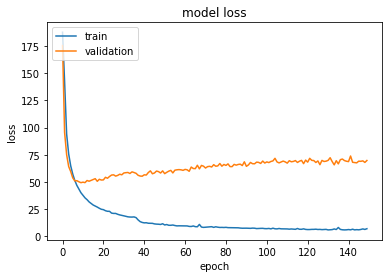

In [91]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [97]:
#loading of model weights
model.load_weights('deepspeech2_trained/training_nonoise100%+timestretch100%/cp.ckpt')

In [28]:
#saving the full model so that it is easily loaded
model.save('deepspeech2_trained/deepspeech2_150epoch_nonoise100%+timestretch100%')

#loading of model
# model = keras.models.load_model('deepspeech2_trained/deepspeech2_150epoch_nonoise100%+timestretch100%', compile=False)

## CTC decoding 

In [42]:
import numpy as np
import tensorflow as tf
from tensorflow.python.ops import ctc_ops as ctc

def ctc_decode(y_pred, input_length, greedy=True, beam_width=100,
               top_paths=100, merge_repeated=True):
    epsilon=1e-7
    y_pred = tf.math.log(tf.transpose(y_pred, perm=[1, 0, 2]) + epsilon)
    input_length = tf.compat.v1.to_int32(input_length)

    if greedy:
        (decoded, log_prob) = ctc.ctc_greedy_decoder(
            inputs=y_pred,
            sequence_length=input_length)
    else:
        (decoded, log_prob) = ctc.ctc_beam_search_decoder(
            inputs=y_pred,
            sequence_length=input_length, beam_width=beam_width,
            top_paths=top_paths, merge_repeated=merge_repeated)

    decoded_dense = [tf.compat.v1.sparse_to_dense(st.indices, st.dense_shape, st.values, default_value=-1)
                     for st in decoded]
    return (decoded_dense, log_prob)

beam_width=100

def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = ctc_decode(pred, input_length=input_len, greedy=False,beam_width=beam_width, top_paths=100,merge_repeated=False)
    return results

In [29]:
#using trained model on test dataset to obtain predictions
#saving predictions and targets in a list
predictions = []
targets = []
i=1 #i is just for visualisation of loading time
for batch in test_dataset:
    print('batch=',i)
    X, y = batch
    print(X)
    batch_predictions = model.predict(X)
    batch_predictions = decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions)    
    for label in y:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        targets.append(label)
    i+=1

In [31]:
#saving the list of predictions and targets for easy inference later
# with open('deepspeech2_trained/deepspeech2_predictions_nonoise100%+timestretch100%', "wb") as file_pi:
#     pickle.dump(predictions,file_pi)
# with open('deepspeech2_trained/deepspeech2_targets', "wb") as file_pi:
#     pickle.dump(predictions,file_pi)

#loading of predictions and targets for evaluation
with open('deepspeech2_trained/deepspeech2_predictions_nonoise100%+timestretch100%', 'rb') as outputfile:
    predictions = pickle.load(outputfile)  
with open('deepspeech2_trained/deepspeech2_targets', 'rb') as outputfile:
    targets=pickle.load(outputfile)

In [32]:
#to create a list of all results and their beam probs with no duplicates
output_text=[]
beam_prob=[]
for i in range(0,len(predictions),2):
    print(i,len(predictions)) #for visualisation of loading time
    for line in range(len(predictions[i][0])):
        count=0
        output_text_temp=[]
        beam_prob_temp=[]
        for j in predictions[i]:
            result = tf.strings.reduce_join(num_to_char(j[line])).numpy().decode("utf-8")
            result = result.strip()
            result = re.sub(' +',' ',result)
            prob = predictions[i+1][line].numpy()[count]
            if result not in output_text_temp:
                output_text_temp.append(result)
                beam_prob_temp.append(prob)
            else:
                idx=output_text_temp.index(result)
                beam_prob_temp[idx]=np.log10(10**beam_prob_temp[idx]+10**prob)
            
            count+=1
        output_text.append(output_text_temp)
        beam_prob.append(beam_prob_temp)

0 76
2 76
4 76
6 76
8 76
10 76
12 76
14 76
16 76
18 76
20 76
22 76
24 76
26 76
28 76
30 76
32 76
34 76
36 76
38 76
40 76
42 76
44 76
46 76
48 76
50 76
52 76
54 76
56 76
58 76
60 76
62 76
64 76
66 76
68 76
70 76
72 76
74 76


In [51]:
#save output_text list
# with open('deepspeech2_trained/deepspeech2_output_text_nonoise100%+timestretch100%', "wb") as file_pi:
#     pickle.dump(predictions,file_pi)

#load output_text list
with open('deepspeech2_trained/deepspeech2_output_text_nonoise100%+timestretch100%', 'rb') as outputfile:
    predictions = pickle.load(outputfile)  
    
#save beam_prob list
# with open('deepspeech2_trained/deepspeech2_beam_prob_nonoise100%+timestretch100%', "wb") as file_pi:
#     pickle.dump(predictions,file_pi)

#load beam_prob list
with open('deepspeech2_trained/deepspeech2_beam_prob_nonoise100%+timestretch100%', 'rb') as outputfile:
    predictions = pickle.load(outputfile) 

In [33]:
#to check individual results for each utterance
line=3

for i in range(len(output_text[line])):
    print(output_text[line][i],beam_prob[line][i]) 
print('target:',targets[line])

figha easy four six two seven -3.4653140644154705
figh easy four six two seven -4.207750197469754
figa easy four six two seven -4.367834173090876
fighat easy four six two seven -5.439209914074219
fig easy four six two seven -5.905374985824475
target: praha easy four six two zero


In [52]:
#create a list of all the best predictions using max of beam prob
best_predictions_no_lm=[]
for i in range(len(beam_prob)):
    best_index=beam_prob[i].index(max(beam_prob[i]))
    best_predictions_no_lm.append(output_text[i][best_index])
    
for i in range(len(best_predictions_no_lm)):
    print('Target:',targets[i])
    print('Prediction:',best_predictions_no_lm[i])
    print('-'*100)

Target: swiss one two four b turn left heading zero one zero
Prediction: swisar two four b turn left heading zero one zero
----------------------------------------------------------------------------------------------------
Target: swissair nine three five nine is identified
Prediction: swissair nine three five nine iidentified
----------------------------------------------------------------------------------------------------
Target: left heading three hundred austrian seven one one z
Prediction: detceding three hounra austrian seven one one z
----------------------------------------------------------------------------------------------------
Target: praha easy four six two zero
Prediction: figha easy four six two seven
----------------------------------------------------------------------------------------------------
Target: csa seven three two two line up runway one three
Prediction: csa seven three si two line up runway one three
---------------------------------------------------

Target: aeroflot one four nine turn right heading two eight zero cleared for ils approach runway three one report localizer established
Prediction: aeroflot one four nine turn right heading two eight zero cleared for ils approach runway three one report localizer established
----------------------------------------------------------------------------------------------------
Target: one four nine
Prediction: one four nine
----------------------------------------------------------------------------------------------------
Target: praha radar good day easy two five eight q one two b passing one thousand seven hundred climbing five
Prediction: owe readayr good day easy two five eight q one two b passing one thousand seven ne onei eight fi
----------------------------------------------------------------------------------------------------
Target: nineteen one good day
Prediction: nineteen one good day
------------------------------------------------------------------------------------------

Prediction: aero lloyd five nine zero milan one three four five two tschuss
----------------------------------------------------------------------------------------------------
Target: one three three . three nine zero ukraine international
Prediction: one three three . three nine zero ukrain n
----------------------------------------------------------------------------------------------------
Target: thirty eight oh six follow the american m d eighty you cleared visual approach runway two seven maintain your speed
Prediction: oeter six five te regor id ite your cleared visual approach runway two seven maintain u speed
----------------------------------------------------------------------------------------------------
Target: scandinavian six one seven contact zurich radar one three four decimal six
Prediction: scandinavian six one seven contact zurich radar one three four decimal six
----------------------------------------------------------------------------------------------------
T

Prediction: speedbird one two four rhein radar identified
----------------------------------------------------------------------------------------------------
Target: november two two zero one charlie follow that traffic to runway two two left after landing hold short of runway two seven descent your discretion although maintain three thousand until ten d m e and then descent your discretion
Prediction: leber two two zero one charlie follow that traffic to runway two two left affter landing hold short of runway two seven descent your discretion o te maintain three thousand an to ten d m e and en descent tou discretion
----------------------------------------------------------------------------------------------------
Target: lufthansa two five three nine descend flight level two nine zero level by letko
Prediction: lufthansa two five three nine descend flight level two nine zero level by ak
------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
Target: k l m three four six turn left heading three five zero
Prediction: k l m three four six turn left heading three five zero
----------------------------------------------------------------------------------------------------
Target: tower csa eight seven nine establish ehm
Prediction: tower csa seven nine establish ehm
----------------------------------------------------------------------------------------------------
Target: zero two se
Prediction: sa zero two se
----------------------------------------------------------------------------------------------------
Target: our inbound p r nine five zero passing two one zero descending one five zero information r one zero one nin
Prediction: n p r n eight five zero passing two ind rero nring ove ive eme ond ntie ree one zero one nin
----------------------------------------------------------------------------------------------------
T

Target: algerie two zero seven three contact zurich one three four decimal six
Prediction: algerie two zero seven three contact zurich one three four decimal six
----------------------------------------------------------------------------------------------------
Target: roger one three four nine two five speedbird one five good bye
Prediction: a one three four nine two five speedbird one five bye bye
----------------------------------------------------------------------------------------------------
Target: five zero air china nine
Prediction: five zero air chi
----------------------------------------------------------------------------------------------------
Target: transwede one zero seven good morning radar contact route trasadingen st prex
Prediction: transwede one zero seven good morning radar contact rout trasadingen st prex
----------------------------------------------------------------------------------------------------
Target: request flight level three two zero if avialabl

Prediction: ogura one three four five two
----------------------------------------------------------------------------------------------------
Target: tag lufthansa five five zero four identified report your heading
Prediction: tag lufthansa five five zero four identified report your heading
----------------------------------------------------------------------------------------------------
Target: e six zero pass
Prediction: o six zero f
----------------------------------------------------------------------------------------------------
Target: aeroflot two five five call me on one three two zero six five
Prediction: aeroflot two five five call me on one three two zero six five
----------------------------------------------------------------------------------------------------
Target: line up and ehm wait
Prediction: line up andeve eight e
----------------------------------------------------------------------------------------------------
Target: onur air three eight eight rhein radar

Target: radar csa two eight w pas
Prediction: radar csa three w pa
----------------------------------------------------------------------------------------------------
Target: sabena eight three eight contact rhein one two seven three seven tschuss
Prediction: sabena eight three eight contact rhein one two seven three seven tschuss
----------------------------------------------------------------------------------------------------
Target: alitalia three hundred climb to flight level three two zero
Prediction: alitalia three hundred climb to flight level three two zero
----------------------------------------------------------------------------------------------------
Target: portugalia five four three geneva one three three decimal one five bye bye
Prediction: portugalia five four three geneva one three three decimal one five bye bye
----------------------------------------------------------------------------------------------------
Target: iberia three four two two right ten degrees
P

Target: lufthansa four three five six contact reims on one three four four bye
Prediction: lufthansa four three five six contact reims on one three four four bye
----------------------------------------------------------------------------------------------------
Target: aero lloyd five six seven contact reims one three four decimal four good bye
Prediction: aero lloyd five six seven two tac reims one three four decima four good bye
----------------------------------------------------------------------------------------------------
Target: one two four four four zero thank you bye bye
Prediction: one three four four four zero ir imlte five eight thank you bye bye
----------------------------------------------------------------------------------------------------
Target: descending nine zero one one nine zero csa
Prediction: descending t zero one one nine zero cs
----------------------------------------------------------------------------------------------------
Target: gulf air zero zer

Target: speedbird five eight zero descend to flight level two one zero
Prediction: speedbird five eight zero descend to flight level two one zero
----------------------------------------------------------------------------------------------------
Target: nine c l descend flight level seven zero seven zero easy nine c l
Prediction: ah c l descend flight level seven zero even zero easy nineig c
----------------------------------------------------------------------------------------------------
Target: high speed descending flight level one zero zero csa five three seven
Prediction: high speed descending flight level one zero zero csa five three seven
----------------------------------------------------------------------------------------------------
Target: cending four thousand feet qnh one zero two one wizzair four x
Prediction: one twro two one wizzair four x
----------------------------------------------------------------------------------------------------
Target: eurotran
Predictio

Target: alitalia four zero four right turn ten degrees
Prediction: alitalia four zero four right turn ten degrees
----------------------------------------------------------------------------------------------------
Target: lauda six eight six nine good morning maintain level three five zero when reaching
Prediction: lauda six eight six nine good morning maintain level three five zero when reacing
----------------------------------------------------------------------------------------------------
Target: ehm one three four nine two five
Prediction: ah one three four nine two five
----------------------------------------------------------------------------------------------------
Target: swissair nine three five nine is identified
Prediction: swissair nine three five nine is identified
----------------------------------------------------------------------------------------------------
Target: transavia seven five zero contact rhein one two eight . zero seven five
Prediction: transavia se

Target: german air force five eight five request your heading
Prediction: german air force five eight five request your reading
----------------------------------------------------------------------------------------------------
Target: india tango sierra oscar kilo contact rhein one two seven decimal three seven bye
Prediction: india thanwo sierra oscar kilo contact rhein one two seven decimal three seven bye
----------------------------------------------------------------------------------------------------
Target: good evening radar contact
Prediction: good evening radar contact
----------------------------------------------------------------------------------------------------
Target: what about now
Prediction: wo a bont iow
----------------------------------------------------------------------------------------------------
Target: beline three p p turn left heading zero four zero heading zero four zero beline
Prediction: beline three p p turn left heading zero four zero descending

Target: cross wayne at three thousand cleared i l s approach precision thirty five seventy one
Prediction: tof eney at three thousand cleared i i l s approach presi cint thirty five seventy one
----------------------------------------------------------------------------------------------------
Target: ehm one six zero conti
Prediction: one six zero conta
----------------------------------------------------------------------------------------------------
Target: o l zu
Prediction: our f
----------------------------------------------------------------------------------------------------
Target: airbridge cargo three eight nine proceed direct rapet
Prediction: air bridge cargo three eight nine proceed direct rapet
----------------------------------------------------------------------------------------------------


In [53]:
#wer with no language model
print('WER with no language_model: ',wer(targets,best_predictions_no_lm))

WER with no language_model:  0.20758515178355746


## Language model

In [37]:
# loading of language model
with open('deepspeech_languagemodel_nltk', 'rb') as fin:
    lm = pickle.load(fin)

#function to allow language model to consider the weighted average of 1-gram, 2-gram and 3-gram probabilities
def everygram_score(word1,word2,word3):
    return 0.5*lm.logscore(word3,(word1+' '+word2).split()) + 0.3*lm.logscore(word3,word2.split()) + 0.2*lm.logscore(word3)
    
#function to calculate scores of sentences
def calculate_score(prediction):
    prediction=prediction.split()
    if len(prediction)==0:
        return everygram_score('<s>','<s>',' ')
    
    for i in range(len(prediction)):
        if i==0:
            score=everygram_score('<s>','<s>',prediction[i])
        elif i==1:
            score+=everygram_score('<s>',prediction[i-1],prediction[i])
        else:
            score+=everygram_score(prediction[i-2],prediction[i-1],prediction[i])
    
    if len(prediction)==1:
        score+=everygram_score('<s>',prediction[-1],'</s>')  
        score+=everygram_score(prediction[-1],'</s>','</s>')  
        
    else:    
        score+=everygram_score(prediction[-2],prediction[-1],'</s>')  
        score+=everygram_score(prediction[-1],'</s>','</s>')  
            
    return score   

In [38]:
#function to obtain a list of best predictions after decoding output of acoustic model with language model
def get_best_predictions(output_text):
    best_predictions=[]
    for line in range(len(output_text)):
        
        max_score=beam_prob[line][0]\
                            +alpha*calculate_score(output_text[line][0])\
                            +beta*len(output_text[line][0].split())
        best_predict=output_text[line][0]
        
        for count in range(1,len(output_text[line])):
            
            confidence_score=beam_prob[line][count]\
                            +alpha*calculate_score(output_text[line][count])\
                            +beta*len(output_text[line][count].split())
            if confidence_score>max_score:
                best_predict = output_text[line][count]
                max_score=confidence_score
            
        
        best_predictions.append(best_predict)
    return best_predictions

In [39]:
#set the weights for decoding step
alpha=1.12
beta=8
best_predictions=get_best_predictions(output_text)

In [40]:
for i in range(len(best_predictions)):
    print('Target:',targets[i])
    print('Prediction:',best_predictions[i])
    print('-'*100)

Target: swiss one two four b turn left heading zero one zero
Prediction: swisar two four b turn left heading zero one zero
----------------------------------------------------------------------------------------------------
Target: swissair nine three five nine is identified
Prediction: swissair nine three five nine identified
----------------------------------------------------------------------------------------------------
Target: left heading three hundred austrian seven one one z
Prediction: detceding three hounra austrian seven one one z
----------------------------------------------------------------------------------------------------
Target: praha easy four six two zero
Prediction: figha easy four six two seven
----------------------------------------------------------------------------------------------------
Target: csa seven three two two line up runway one three
Prediction: csa seven three s two line up runway one three
-----------------------------------------------------

Target: lu lufthansa six j t negative one three four . eight seven five
Prediction: lufthansa six j negative one three four . eight seven five
----------------------------------------------------------------------------------------------------
Target: who is it calling at level three three zero please
Prediction: whos i calling level three three zero please
----------------------------------------------------------------------------------------------------
Target: meridiana six nine four four contact zurich one three four six tschuss
Prediction: meridiana six nine four four contact zurich one three four six tschuss
----------------------------------------------------------------------------------------------------
Target: rect
Prediction: you
----------------------------------------------------------------------------------------------------
Target: britannia three zero six alfa is identified
Prediction: britannia three zero six alfa is identified
--------------------------------------

----------------------------------------------------------------------------------------------------
Target: ryanair six seven two nine contact praha one three three . four one zero good bye
Prediction: ainryanair six seven two nine contact praha one three three . four one zero good bye
----------------------------------------------------------------------------------------------------
Target: hallo
Prediction: a o
----------------------------------------------------------------------------------------------------
Target: air france one three two right heading
Prediction: air france one three two right heading
----------------------------------------------------------------------------------------------------
Target: good morning alitalia four eight seven radar contact maintain flight level two nine zero trasadingen canne
Prediction: good morning alitalia four eight seven radar contact maintain flight level two nine zero trasadingen canne
-----------------------------------------------

----------------------------------------------------------------------------------------------------
Target: o ki
Prediction: o
----------------------------------------------------------------------------------------------------
Target: airfrans six seven three climb to flight level three six zero
Prediction: airfrans six seven three climb to flight level three six zero
----------------------------------------------------------------------------------------------------
Target: flight level seven zero csa nine zero five
Prediction: flight leve o seven zero csa nine zero five
----------------------------------------------------------------------------------------------------
Target: condor triple six do you request higher level
Prediction: condor triple six two you request fingtl level
----------------------------------------------------------------------------------------------------
Target: ah delta echo charlie i'm not sure whether you got it you proceed to dinkelsbuhl
Prediction: ahd

Prediction: p two zero eight contact warsaw one three four eight seven fi
----------------------------------------------------------------------------------------------------
Target: one one nine zero lufthansa three k a minimum clean
Prediction: four nine zero lufthansa six k a t
----------------------------------------------------------------------------------------------------
Target: lufthansa seven one four contact warsaw one three four . eight seven five g
Prediction: lufthansa seven one four contact warsaw one three four . eight seven five
----------------------------------------------------------------------------------------------------
Target: descend flight level seven zero
Prediction: descend flight level seven zero
----------------------------------------------------------------------------------------------------
Target: portugalia five four three your rate of climb
Prediction: potugalia five four three your rate of climb
--------------------------------------------------

Target: sabena eight three six rhein one two seven three seven tschuss
Prediction: sabena eight three six rhein one two seven three seven chuss
----------------------------------------------------------------------------------------------------
Target: lufthansa five two one seven is identified
Prediction: lufthansa five two one seven is identified
----------------------------------------------------------------------------------------------------
Target: lufthansa three five five six climb to flight level two nine zero
Prediction: lufthansa three five five six climb to flight level two nine zero
----------------------------------------------------------------------------------------------------
Target: correct information k qnh one zero two two
Prediction: rand information k qnh one zero two two
----------------------------------------------------------------------------------------------------
Target: six zero two three call you when leaving
Prediction: six zero two three call you an

Prediction: b two six nine six s vacate to the right ap an contact ground one two one . nine on sqewk onen
----------------------------------------------------------------------------------------------------
Target: aeroflot one two three
Prediction: sereoflot one four three f g
----------------------------------------------------------------------------------------------------
Target: csa seven a j runway one three clear to land wind zero eight zero degrees six knots
Prediction: csa seven a runway one three clear to land wind zero ero zero degrees six knots
----------------------------------------------------------------------------------------------------
Target: m a climb level three three zero
Prediction: flib level three zer zero
----------------------------------------------------------------------------------------------------
Target: airfrans ah three five six good afternoon squawk seven five three six
Prediction: airfrans ah three five six good afternoon squawk seven five thre

Target: swiss four seven two e tower good morning continue approach
Prediction: swiss four seven two e tower good morning continue approach
----------------------------------------------------------------------------------------------------
Target: tag tarom three seven two identified
Prediction: tag tarom three seven two identified
----------------------------------------------------------------------------------------------------
Target: squawk one
Prediction: n sqoak o
----------------------------------------------------------------------------------------------------
Target: d flight level two nine ze
Prediction: descend flight level three nine ze
----------------------------------------------------------------------------------------------------
Target: quality ehm eight nine s
Prediction: quality ehm eight nine
----------------------------------------------------------------------------------------------------
Target: lufthansa four six five two turn right to st prex climb to fli

Prediction: right heading two five zero rleir to at or above ah ea seven a cherd i l s ah te seventwest one eighty two
----------------------------------------------------------------------------------------------------
Target: praha good evening austrian one z established one three speed one seven zero knots
Prediction: pragae eing austrian seven one two stablishe one three speed one seven zero knots
----------------------------------------------------------------------------------------------------
Target: november one four five whiskey bonjour squawk five seven seven three
Prediction: november one four five whiskey bonjour squawk five seven seven three
----------------------------------------------------------------------------------------------------
Target: quality nine one r praha hello radar contact on present heading climb to flight level two eight zero
Prediction: quality nine one r praha hello radar contact on present heading climb to flight level two eight zero
-------------

Prediction: aitari six zero five six proceed direct omis
----------------------------------------------------------------------------------------------------
Target: skytravel one zero one zero climb to flight level one six zero
Prediction: skytravel one zero one zero climb to flight level one six zero
----------------------------------------------------------------------------------------------------
Target: swissair six five two zero call rhein on one two seven three seven
Prediction: swissair six five two zero call rhein on one two seven three seven
----------------------------------------------------------------------------------------------------
Target: skytravel one two double zero ehm
Prediction: skytravel one two zero zero si
----------------------------------------------------------------------------------------------------
Target: easy nine c l speed two two zero knots or less
Prediction: sa nine c l speed two two zero knots or less
------------------------------------------

Prediction: u s air fifteen twenty four traffic landing runway two two left will hold short of your runway speed you contact the tower one one niner point one good day
----------------------------------------------------------------------------------------------------
Target: transavia three eight one zurich radar one three four decimal six
Prediction: transavia three eight one zurich radar one three four decimal six
----------------------------------------------------------------------------------------------------
Target: csa seven five eight report heading on frequency one two zero . two seven five
Prediction: csa seven five eight report ready ef sacing three one two zero two seven five
----------------------------------------------------------------------------------------------------
Target: qnh one zero two zero and four thousand feet o k d s j
Prediction: qnh one zero two zero in four thousand feet o k d s j
-----------------------------------------------------------------------

Target: bonjour three squawk five seven four six
Prediction: bonjour speedbird it tpe pie ae squawk five seven four six
----------------------------------------------------------------------------------------------------
Target: no problem trasadingen canne
Prediction: natromom trasadingen canne
----------------------------------------------------------------------------------------------------
Target: alitalia four zero one ah guten tag maintain three three zero
Prediction: alitalia four zero one ah guten tag intain three three zero
----------------------------------------------------------------------------------------------------
Target: jet set one four two nine rhein radar identified
Prediction: jet set one four two nine rhein radar identified
----------------------------------------------------------------------------------------------------
Target: lufthansa four two zero nine descend now flight level two seven zero increase the rate to two thousand feet per minute or more
Predi

Prediction: speedway three three five two good afternoon route zurich east fusse
----------------------------------------------------------------------------------------------------
Target: swiss one two four b contact radar one one eight . one good bye resume one eight one bye bye swiss one two four b
Prediction: swiss one two four b contact tower one one eight . one good bye tor biye is on the e no one
----------------------------------------------------------------------------------------------------
Target: csa nine six seven radar
Prediction: csa nine six seven radar
----------------------------------------------------------------------------------------------------
Target: transwede one zero one contact zurich one three three four tschuss
Prediction: transwede one zero one contact zurich one three three four tschuss
----------------------------------------------------------------------------------------------------
Target: wizzair four m r hello radar contact
Prediction: wizzair 

Prediction: united six nine good afternoon radar contact descend cleane to cleare ten mils
----------------------------------------------------------------------------------------------------
Target: sa two five two six
Prediction: hansa five
----------------------------------------------------------------------------------------------------
Target: five good bye
Prediction: seven good bye
----------------------------------------------------------------------------------------------------
Target: three five d taxi via g b z a va
Prediction: t sine d s g b
----------------------------------------------------------------------------------------------------
Target: ehm quality eight nine s we need to full length
Prediction: ehm approach ey o for x
----------------------------------------------------------------------------------------------------
Target: india oscar kilo roger further climb contact radar one three three decimal four bye bye
Prediction: india oscar kilo roger further climb

Target: lufthansa four seven zero zero climb to flight level three four zero own navigation st prex
Prediction: lufthansa four seven zero zero climb to flight level three four zero own navigation st prex
----------------------------------------------------------------------------------------------------
Target: cimber zero two nine praha good morning radar contact
Prediction: cimber zero two nine praha good morning radar contact
----------------------------------------------------------------------------------------------------
Target: runway one three cleared to land j z
Prediction: runway ae three three two one jobair two
----------------------------------------------------------------------------------------------------
Target: hamburg air two five zero two contact geneva one three three one five bye bye
Prediction: hamburg air two five zero two contact geneva one three three one five bye bye
-------------------------------------------------------------------------------------------

Target: klm one eight four five climb to flight level three four zero and contact praha one three three . three nine zero
Prediction: klm one eight four five climb to flight level three four zero and contact praha one three three . three nine zero
----------------------------------------------------------------------------------------------------
Target: maintaining one three zero zero one three ze
Prediction: ehm caning one three zero zero one three ze
----------------------------------------------------------------------------------------------------
Target: three three four one zero csa nine three zero
Prediction: three three four one zero csa nine three zero
----------------------------------------------------------------------------------------------------
Target: alitalia two four two climb to flight level three zero zero
Prediction: alitalia two four two climb to flight level three zero zero
----------------------------------------------------------------------------------------

Prediction: by
----------------------------------------------------------------------------------------------------
Target: airfrans two four two six right by one five degrees
Prediction: airfrans two four two six right by one five degrees
----------------------------------------------------------------------------------------------------
Target: o a l z i request to descend and change frequency to one two
Prediction: request to descend ng regasy one two
----------------------------------------------------------------------------------------------------
Target: three zero french
Prediction: zero
----------------------------------------------------------------------------------------------------
Target: thank you
Prediction: thank you
----------------------------------------------------------------------------------------------------
Target: german wings seven p contact praha radar one two seven . five seven five
Prediction: german wings seven p contact prah radar one two seven . five s

----------------------------------------------------------------------------------------------------
Target: lufthansa four six five two contact geneva one three four decimal correction one three three one five
Prediction: lufthansa four six five two contact geneva one three four decimal s correction on one three three one five
----------------------------------------------------------------------------------------------------
Target: good morning austrian seven zero three tower continue apporach speed one six zero knots till four miles final departures ahead
Prediction: good morning austrian seven zero three tower continue approach speed one six zero knots til four miles final departure serm
----------------------------------------------------------------------------------------------------
Target: lufthansa four six five two direct st prex
Prediction: lufthansa four six five two direct st peex
-------------------------------------------------------------------------------------------

Prediction: o k
----------------------------------------------------------------------------------------------------
Target: condor nine seven two contact zurich one three three decimal four
Prediction: mondar nine seven two contact zurich one three three decimal four
----------------------------------------------------------------------------------------------------
Target: by a left turn to heading
Prediction: oing let three
----------------------------------------------------------------------------------------------------
Target: lufthansa five y v ground one two one . nine good by
Prediction: lufthansa five y t is one two one nine
----------------------------------------------------------------------------------------------------
Target: sabena seven eight one six own navigation direct karlsruhe
Prediction: sabena seven eight one six own navigation direct karlsruhe
----------------------------------------------------------------------------------------------------
Target: csa nine

----------------------------------------------------------------------------------------------------
Target: aero lloyd five one seven turn left heading zero one zero
Prediction: aero lloyd five one seven turn left heading zero one zero
----------------------------------------------------------------------------------------------------
Target: lufthansa three five five zero further contact milan on ah one tw three four decimal five two bye bye
Prediction: lufthansa three five five zero further contact milan on one two three four decimal five two bye bye
----------------------------------------------------------------------------------------------------
Target: scandinavian six eight seven is identified
Prediction: scandinavian six eight seven is identified
----------------------------------------------------------------------------------------------------
Target: german air force five eight five rhein radar do you read
Prediction: german air force five eight five rhein radar do you rea

Prediction: seven one o run way int in sight
----------------------------------------------------------------------------------------------------
Target: csa zero two five heading three one five descend flight level nine zero
Prediction: csa zero two five heading three one five descend flight level nine zero
----------------------------------------------------------------------------------------------------
Target: alitalia four zero four right turn ten degrees
Prediction: alitalia four zero four right turn ten degrees
----------------------------------------------------------------------------------------------------
Target: lauda six eight six nine good morning maintain level three five zero when reaching
Prediction: lauda six eight six nine good morning maintain level three five zero when reaching
----------------------------------------------------------------------------------------------------
Target: ehm one three four nine two five
Prediction: ah one three four nine two five
--

Target: hamburg air two five four six bonjour identified cleared passeiry la tour du pin flight level three zero zero
Prediction: hamburg air two five four six bonjour identified cleared passeiry la tour du pin flight level three zero zero
----------------------------------------------------------------------------------------------------
Target: lufthansa four six five two contact geneva one three three one five bye bye
Prediction: lufthansa four six five two contact geneva one three three one five bye bye
----------------------------------------------------------------------------------------------------
Target: vectors for short
Prediction: m g vctr for short
----------------------------------------------------------------------------------------------------
Target: lufthansa triple five zero own navigation to st prex
Prediction: lufthansa triple five zero own navigation to st prex
----------------------------------------------------------------------------------------------------
T

Target: one three ehm skyt
Prediction: one three m d
----------------------------------------------------------------------------------------------------
Target: take off runway one three easy five four nine eight good night
Prediction: sangapa one three easy five four one eight good bye
----------------------------------------------------------------------------------------------------
Target: bee med one report your heading
Prediction: bee med one report your heading
----------------------------------------------------------------------------------------------------
Target: german air force five eight five report heading
Prediction: german air force five eight five report heading
----------------------------------------------------------------------------------------------------
Target: six j t level cimbing level three four zero
Prediction: six j t climbing level three four zero
----------------------------------------------------------------------------------------------------
Targ

Prediction: aeroloa four one h leavi flight level three two zero to direct level two five zero
----------------------------------------------------------------------------------------------------
Target: lufthansa three six three eight climb flight level three seven zero
Prediction: lufthansa three six three eight climb flight level three seven zero
----------------------------------------------------------------------------------------------------
Target: o k s contact ground one two one nine
Prediction: o k s contact ground one two one nine
----------------------------------------------------------------------------------------------------
Target: wizzair four p u line up runway three one and clear for take off wind one eight zero degrees six knots nasly
Prediction: wizzair four p u line up runway three one and clear for take off wind one eight zero degrees six knots no please
----------------------------------------------------------------------------------------------------
Target:

In [41]:
word_error_rate=wer(targets,best_predictions)
print('WER with language model: ',word_error_rate)

WER with language model:  0.19276914405346646


## Spell Checker

In [43]:
#spelling corrector

#open probability list of words in training dataset
with open('deepspeech2_trained/autocorrect_probability', 'rb') as fin:
    probs = pickle.load(fin)

#function to return top 3 similar words of misspelt words
def autocorrect(input_word):
    if input_word in probs.keys():
        pass
    else:
        sim = [1-(textdistance.levenshtein.normalized_distance(v,input_word)+textdistance.Jaccard(qval=2).distance(v,input_word))/2 for v in probs.keys()]
        df = pd.DataFrame.from_dict(probs, orient='index').reset_index()
        df = df.rename(columns={'index':'Word', 0:'Prob'})
        df['Similarity'] = sim
        output = df.sort_values(['Similarity', 'Prob'], ascending=False)[0:3]['Word']
        return(output)

#function to correct misspelt words based on language model    
def get_corrected_sentence(prediction):
    prediction=prediction.split()
    for i in range(len(prediction)):

        if prediction[i] not in probs.keys():
            
            if i==len(prediction)-1:

                if i==0:
                    word_score=(everygram_score('<s>','<s>',prediction[i]) + everygram_score('<s>',prediction[i],'</s>'))/2
                elif i==1:
                    word_score=(everygram_score('<s>',prediction[i-1],prediction[i]) + everygram_score(prediction[i-1],prediction[i],'</s>'))/2
                else:
                    word_score=(everygram_score(prediction[i-2],prediction[i-1],prediction[i]) + everygram_score(prediction[i-1],prediction[i],'</s>'))/2

                for corrected_word in autocorrect(prediction[i]):
                    if i==0:
                        corrected_word_score=(everygram_score('<s>','<s>',corrected_word) + everygram_score('<s>',corrected_word,'</s>'))/2
                    elif i==1:
                        corrected_word_score=(everygram_score('<s>',prediction[i-1],corrected_word) + everygram_score(prediction[i-1],corrected_word,'</s>'))/2
                    else:
                        corrected_word_score=(everygram_score(prediction[i-2],prediction[i-1],corrected_word) + everygram_score(prediction[i-1],corrected_word,'</s>'))/2

                    #this is statement determines if it is worth to change misspelt word based on language model
                    if corrected_word_score>word_score:
                        word_score = corrected_word_score
                        prediction[i]=corrected_word
                    
            else:

                if i==0:
                    word_score=(everygram_score('<s>','<s>',prediction[i]) + everygram_score('<s>',prediction[i],prediction[i+1]))/2
                elif i==1:
                    word_score=(everygram_score('<s>',prediction[i-1],prediction[i]) + everygram_score(prediction[i-1],prediction[i],prediction[i+1]))/2
                else:
                    word_score=(everygram_score(prediction[i-2],prediction[i-1],prediction[i]) + everygram_score(prediction[i-1],prediction[i],prediction[i+1]))/2
               
                for corrected_word in autocorrect(prediction[i]):
                    if i==0:
                        corrected_word_score=(everygram_score('<s>','<s>',corrected_word) + everygram_score('<s>',corrected_word,prediction[i+1]))/2
                    elif i==1:
                        corrected_word_score=(everygram_score('<s>',prediction[i-1],corrected_word) + everygram_score(prediction[i-1],corrected_word,prediction[i+1]))/2
                    else:
                        corrected_word_score=(everygram_score(prediction[i-2],prediction[i-1],corrected_word) + everygram_score(prediction[i-1],corrected_word,prediction[i+1]))/2

                    
                    if corrected_word_score > word_score:
                        word_score = corrected_word_score
                        prediction[i]=corrected_word  
                    
    return ' '.join(prediction)



In [44]:
#getting a list of corrected utterances
best_predictions_corrected=[]
count=0 #count is just for visualisation of loading time
for line in best_predictions:
    print(count)
    count+=1
    corrected_line=get_corrected_sentence(line)
    best_predictions_corrected.append(corrected_line)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [45]:
for i in range(len(best_predictions_corrected)):
    print('prediction_spellchecker: ',best_predictions_corrected[i],'\nprediction_lm: ',best_predictions[i],'\nprediction_nolm',best_predictions_no_lm[i],'\ntargets: ',targets[i])
    print('-'*100)

prediction_spellchecker:  swissair two four b turn left heading zero one zero 
prediction_lm:  swisar two four b turn left heading zero one zero 
prediction_nolm swisar two four b turn left heading zero one zero 
targets:  swiss one two four b turn left heading zero one zero
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  swissair nine three five nine identified 
prediction_lm:  swissair nine three five nine identified 
prediction_nolm swissair nine three five nine iidentified 
targets:  swissair nine three five nine is identified
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  heading three four austrian seven one one z 
prediction_lm:  detceding three hounra austrian seven one one z 
prediction_nolm detceding three hounra austrian seven one one z 
targets:  left heading three hundred austrian seven one one z
--------------------

----------------------------------------------------------------------------------------------------
prediction_spellchecker:  praha good evening easy eight zero nine b fully established one three nine miles 
prediction_lm:  praha good evening easy eight zero nine b fully established one three ine miles 
prediction_nolm praha good evenig easy eight zero nine b fully established one three ine miles 
targets:  praha good evening easy eight zero nine b fully established one three nine miles
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  sabena eight two six alfa good morning squawk seven five three one 
prediction_lm:  sabena eight two six alfa good morning squawk seven five three one 
prediction_nolm sabena eight two six alfa good morning squawk seven five three one 
targets:  sabena eight two six alfa good morning squawk seven five three one
-------------------------------------------------------------------

prediction_lm:  len runway one three via d 
prediction_nolm len runway one three via 
targets:  point ehm runway one three via z ehm b and d
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  tower go nine 
prediction_lm:  tower go moninha 
prediction_nolm towe god moninha 
targets:  tower good morning cimber
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  n tw 
prediction_lm:  n tw 
prediction_nolm e n tw 
targets:  one air malta
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  swissair four eight eight own navigation tango 
prediction_lm:  swissair four eight eightre own navigation tango 
prediction_nolm swissair four eight eightre own navigation tango 
targets:  swissair four eight eight own navigation tango
----------------------------------------------

prediction_lm:  delta seventeen seventy six elog 
prediction_nolm delta seventeen seventy six elog 
targets:  delta seventeen seventy six so long
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  zero eight two three eight five 
prediction_lm:  zero eight two three eight ive 
prediction_nolm zero eight two three eight ine 
targets:  zero two three affirm
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  csa three seven b descend flight level one one zero 
prediction_lm:  csa three seven b descend flight level one one zeroero 
prediction_nolm csa three seven b descend flight level one one zeroero 
targets:  csa three seven b descend flight level one one zero
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  csa four zero seven altitude four thousand feet qnh o

prediction_lm:  condor six zero seven own navigation direct to willisau 
prediction_nolm condor six zero seven own navigation direct to willisau 
targets:  condor six zero seven own navigation direct to willisau
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  aeroflot one four nine turn right heading two eight zero cleared for ils approach runway three one report localizer established 
prediction_lm:  aeroflot one four nine turn right heading two eight zero cleared for ils approach runway three one report localizer established 
prediction_nolm aeroflot one four nine turn right heading two eight zero cleared for ils approach runway three one report localizer established 
targets:  aeroflot one four nine turn right heading two eight zero cleared for ils approach runway three one report localizer established
----------------------------------------------------------------------------------------------------
pre

prediction_spellchecker:  zero 
prediction_lm:  zero 
prediction_nolm zero 
targets:  two seven
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  tag swissair eight zero six identified climb to flight level three one zero 
prediction_lm:  tag swissair eight zero six identified climb to flight level three one zero 
prediction_nolm tag swissair eight zero six identified climb to flight level three one zero 
targets:  tag swiss eight zero six identified climb to flight level three one zero
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  france one three two five five five a good day 
prediction_lm:  nci one three two five five five a good day 
prediction_nolm nci one three two five five five a good day 
targets:  one three two one five five d h a good day
---------------------------------------------------------------------------------

prediction_spellchecker:  turn nine one correct descend to flight level two five zero 
prediction_lm:  turn nine one correct descend to flight level two five zero 
prediction_nolm tura nine one correct descend to flight level two five zero 
targets:  two nine one correct descend to flight level two five zero
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  wizzair 
prediction_lm:  wizzair 
prediction_nolm wizzair 
targets:  wizzair fi
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  would ro 
prediction_lm:  wounenove ro 
prediction_nolm wounenove ro 
targets:  good evening
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  malaysian four is identified 
prediction_lm:  malaysian four is identified 
prediction_nolm malaysian four is identified 
targets:  mala

targets:  swiss four six zero t tower good morning continue approach
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  you as ten heading ah one eighty e for y g go again six 
prediction_lm:  you as renpc heading ah one eity e fort y g go attin six 
prediction_nolm you as renpc heading ah one eity e fort y g go attin six 
targets:  you normally expect a heading ah once you get before you get to that ah fix
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  sabena nine three six nine good afternoon maintain two nine zero call you back for further descent out four minutes and se fusse de 
prediction_lm:  sabena nine three six nine good afternoon maintain two nine zero call you backr for further descent out four minutes and se cussiy de 
prediction_nolm sabena nine three six nine good afternoon maintain two nine zero call you backr for fu

----------------------------------------------------------------------------------------------------
prediction_spellchecker:  six zero two three call you any 
prediction_lm:  six zero two three call you any 
prediction_nolm six zero two three call you any 
targets:  six zero two three call you when leaving
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  csa six three five track distance to touch down six five miles 
prediction_lm:  csa six three five track distance to touch down six five miles 
prediction_nolm csa six three fivetrack distance to touch down six five miles 
targets:  csa six three five track distance to touch down six five miles
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  delta vienna is identified fly heading one seven zero climb to flight level two seven zero 
prediction_lm:  delta chiena is identified fly he

targets:  csa seven a j runway one three clear to land wind zero eight zero degrees six knots
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  flight level three zer zero 
prediction_lm:  flib level three zer zero 
prediction_nolm flib level three zer zero 
targets:  m a climb level three three zero
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  airfrans ah three five six good afternoon squawk seven five three six 
prediction_lm:  airfrans ah three five six good afternoon squawk seven five three six 
prediction_nolm airfrans ah three five six good afternoon squawk seven five three six 
targets:  airfrans ah three five six good afternoon squawk seven five three six
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  aero lloyd five six two zurich one three f

prediction_lm:  lot three six two descend to flight level two nine zero and contact praha one two seven one two five 
prediction_nolm lot three six two descend flight level two nine zero and contact praha one two seven one two five 
targets:  lot three six two descend to flight level two nine zero and contact praha one two seven one two five
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  is a force ehm two four eight three bravo ehm 
prediction_lm:  is ae fote ehm two four eight three vo ehm 
prediction_nolm is ae fote ehm two four eight three vo em 
targets:  two four eight three
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  e three n descend flight level two five z 
prediction_lm:  e three n descend flight level two five z 
prediction_nolm e three n descend flight level two five zi 
targets:  f clear on descend flight level t

prediction_nolm l t u seven seven five six ah geneva one two eight one five good bye 
targets:  l t u seven seven five six ah geneva one two eight one five good bye
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  csa eight m two contact radar one two zero . two seven five 
prediction_lm:  csa eight m two contact radar one two zero . two seven five 
prediction_nolm csa eight m two contact radar one two zero . two seven five 
targets:  csa eight m two contact radar one two zero . two seven five
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  sunwing five two zero three good morning maintain level three four zero trasadingen tango 
prediction_lm:  sunwing five two zero three good morning maintain level three four zero trasadingen tango 
prediction_nolm sunwing five two zero three good morning maintain level three four zero trasadinge

prediction_nolm swissair four eight eight climb to flight level three two zero 
targets:  swissair four eight eight climb to flight level three two zero
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  three six zero four and for further climb zurich six to one three four decimal zurich one three three decimal four bye bye 
prediction_lm:  three six zero four and for further climb zurich sic to one three four decimal zury one three three decimal four bye bye 
prediction_nolm three six zero four and for further climb zurich sic o one three four decimal zury one three three decimal four bye bye 
targets:  three six zero four and for further climb zurich sector one three four decim sorry one three three decimal four bye bye
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  roger so heading less so 
prediction_lm:  roger soll heading upe

prediction_nolm two eiht csa 
targets:  three csa
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  csa seven six four contact praha radar one two zero . two seven five 
prediction_lm:  csa seven six four contact praha radar one two zero . two seven five 
prediction_nolm csa seven six four contact praha radar one two zero . two seven five 
targets:  csa seven six four cotnact praha radar one two zero . two seven five
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  to o w air france one nine eight two ils runway three one 
prediction_lm:  ao o w air france one nine eight two ils runway three one 
prediction_nolm ao o w air france one nine eight two ils runway three one 
targets:  tower good afternoon air france one nine eight two ils runway three one
------------------------------------------------------------------------------------

prediction_lm:  aitari six zero five six proceed direct omis 
prediction_nolm aitari six zero five six proceed direct omis 
targets:  quatari six zero five six proceed direct romis
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  skytravel one zero one zero climb to flight level one six zero 
prediction_lm:  skytravel one zero one zero climb to flight level one six zero 
prediction_nolm skytravel one zero one zero climb to flight level one six zero 
targets:  skytravel one zero one zero climb to flight level one six zero
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  swissair six five two zero call rhein on one two seven three seven 
prediction_lm:  swissair six five two zero call rhein on one two seven three seven 
prediction_nolm swissair six five two zero call rhein on one two seven three seven 
targets:  swissair six five two 

prediction_lm:  alitalia four zero one turn left heading one seven zero 
prediction_nolm alitalia four zero one turn left heading one seven zero 
targets:  alitalia four zero one turn left heading one seven zero
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  europa three six three contact rhein one two seven decimal three seven 
prediction_lm:  europa three six three contact rhein one two seven decimal three seven 
prediction_nolm europa three six three contact rhein one two seven decimal three seven 
targets:  europa three six three contact rhein one two seven decimal three seven
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  hello air four thousand feet roger stand by 
prediction_lm:  fkenlo maair four thousand feet orohem stand by 
prediction_nolm fkenlo maair four thousan feet orohem stand by 
targets:  o maintain four thous

prediction_lm:  affirm lufthansa four three nine zero contact zurich one three four decimal six 
prediction_nolm affirm lufthansa four three nine zero contact zurich one three four decimal six 
targets:  affirm lufthansa four three nine zero contact zurich one three four decimal six
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  the eight zero three on ready descend flight level two nine zero o rhein you 
prediction_lm:  th eight zero three on ready descend flight level two nine zero o bein nou 
prediction_nolm th eight zero three on ready descend flight level two nine zero o bein nou 
targets:  csa eight zero three when ready descend flight level two nine zero leaving now
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  lufthansa five eight climb flight level three three zero 
prediction_lm:  lafthasan five eight climb flight lev

prediction_lm:  o s j continue present heading vectoring ils approach runway three one descend flight level one zero zero 
prediction_nolm o s j continue present heading vectoring ils approach runway three one descend flight level one zero zero 
targets:  o s j continue present heading vectoring ils approach runway three one descend flight level one zero zero
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  lufthansa three a n co 
prediction_lm:  lufthansa three a n co 
prediction_nolm lufthansa three p n co 
targets:  lufthansa three a n pro
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  ryanair one one three contact munich one three two . one five five good morning 
prediction_lm:  omanair one one three contact munuch one three two . one five five good morni 
prediction_nolm omanair one one three contact munuch one three two . o

prediction_lm:  right sent heading one hundred cleared ils runway 
prediction_nolm right sent heading one hundred cleared ils runway 
targets:  right turn heading one hundred cleared ils runway
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  climb flight level three six zero 
prediction_lm:  climb flight level three six zerola 
prediction_nolm climb flight level three six zerola 
targets:  climb flight level three six zero and be level by cerno
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  csa five four five runway one three clear 
prediction_lm:  csa five four five runway one three clear 
prediction_nolm csa five four five runway one three clea 
targets:  easy five four five runway one three clea
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  easy t

prediction_spellchecker:  delta india bravo echo charlie is identified good afternoon 
prediction_lm:  delta india bravo echo charlie is identified good afternoon 
prediction_nolm delta india bravo echo charlie is identified good afternoon 
targets:  delta india bravo echo charlie is identified good afternoon
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  in two four zero reduce speed lot one eight seven 
prediction_lm:  in two four zero reduce speed lo one eight seven 
prediction_nolm in two foue zero reduce speed lo one eight seven 
targets:  heading two five zero reduce speed one eight zero
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  left heading zero eight zero descending four thousand feet on qnh one zero two two csa seven five nine 
prediction_lm:  left heading zero eight zero descending four thousand feet on qnh one ze

prediction_spellchecker:  five zero air china 
prediction_lm:  five zero air chi 
prediction_nolm five zero air chi 
targets:  five zero air china nine
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  transwede one zero seven good morning radar contact route trasadingen st prex 
prediction_lm:  transwede one zero seven good morning radar contact route trasadingen st prex 
prediction_nolm transwede one zero seven good morning radar contact rout trasadingen st prex 
targets:  transwede one zero seven good morning radar contact route trasadingen st prex
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  request flight level three two zero is available affirm climb flight level three two zero 
prediction_lm:  request flight level three two zero ifs aible affirm climb flight level three two zero 
prediction_nolm request flight level three 

prediction_nolm aeroflot two five five call me on one three two zero six five 
targets:  aeroflot two five five call me on one three two zero six five
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  line up and eight e 
prediction_lm:  line up andeve eight e 
prediction_nolm line up andeve eight e 
targets:  line up and ehm wait
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  onur a jet it rhein radar identified 
prediction_lm:  onur a juett it rhein radar identified 
prediction_nolm onur a juett it rhein radar identified 
targets:  onur air three eight eight rhein radar identified
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  lufthansa four three nine zero contact milano one three four decimal five decimal five two 
prediction_lm:  lufthansa four thr

prediction_spellchecker:  roger contact approach one two seven five seven five good 
prediction_lm:  roger contact approach one two seven five seven five good 
prediction_nolm roger contact approach one two seven five seven five good 
targets:  roger contact approach one two seven five seven five good
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  yeah for a for air france one zero eight two affirm clear for ils one three thank you 
prediction_lm:  ye for a far air france one zero eight two affirm clear for ils one three thank you 
prediction_nolm ye for a far air france one zero eight two affirm clear for ils one three thank you 
targets:  cleared for approach air france one zero eight two affirm cleared for ils one three thank you
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  ehm i turn ehm s two k g 
prediction_lm:  ehm i tu

prediction_spellchecker:  seven three seven 
prediction_lm:  seven three send 
prediction_nolm seven three send 
targets:  three sev
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  speedbird five eight zero contact marseille one two five eight five good bye 
prediction_lm:  speedbird five eight zero contact marseille one two five eight five good bye 
prediction_nolm speedbird five eight zero contact marseille one two five eight five good bye 
targets:  speedbird five eight zero contact marseille one two five eight five good bye
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  skytravel six three two climb level one six zero on course to radar 
prediction_lm:  skytravel six three two climb level one six zero on course to raa 
prediction_nolm skytravel six three two climb levl one six zero on course to raa 
targets:  skytravel six ei

----------------------------------------------------------------------------------------------------
prediction_spellchecker:  u s air one four fly heading o in zero nine zero 
prediction_lm:  u s air one four fly heading o in zero nine zero 
prediction_nolm u s air one four fly heading ou in zero nine zero 
targets:  u s air one four fly heading now again zero nine zero
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  one one eight four 
prediction_lm:  one one eight four 
prediction_nolm one one eight four 
targets:  one one eight fou
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  roger ah what is your position 
prediction_lm:  roger ah what is your position 
prediction_nolm roger ah what is your pocition 
targets:  roger what is your position
--------------------------------------------------------------------------------------

prediction_spellchecker:  lot three zero five report expect line climb at flight level three six zero 
prediction_lm:  lot three zero five report expect lie climb at flight level three six zero 
prediction_nolm lot three zero five report expect lie climb a flight level three six zero 
targets:  lot three zero five report expected mach number at flight level three six zero
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  alitalia six four seven four contact rhein radar one two seven decimal three seven 
prediction_lm:  alitalia six four seven four contact rhein radar one two seven decimal three seven 
prediction_nolm alitalia six four seven four contact rhein radar one two seven decimal three seven 
targets:  alitalia six four seven four contact rhein radar one two seven decimal three seven
----------------------------------------------------------------------------------------------------
prediction_spellchec

prediction_nolm slwin to one seventy united three five two heavy 
targets:  slow to one seventy united three five two heavy
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  austrian three three one contact rhein 
prediction_lm:  austrian three three one contact rhei 
prediction_nolm austrian three three one contact rhei 
targets:  trian three three one contact rhei
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  three four zero 
prediction_lm:  three four zero 
prediction_nolm three four zero 
targets:  three four zero
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  lufthansa three five six six climb to flight level three four zero 
prediction_lm:  lufthansa three five six six climb to flight level three four zero 
prediction_nolm lufthansa three five si

prediction_lm:  dprture hello wizzair four two thousand climbing five thousand on wien one b 
prediction_nolm dprture hello wizzair four two thousand climbing five thousand on witeen one b 
targets:  departure hello wizzair four q s two thousand climbing five thousand on voz one b
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  lufthansa three five six six for higher level zurich one three three four good bye 
prediction_lm:  lufthansa three five six six for higher level zurich one three three four good bye 
prediction_nolm lufthansa three five six six for higher level zurich one three three four good bye 
targets:  lufthansa three five six six for higher level zurich one three three four good bye
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  csa six eight nine descend flight level nine zero 
prediction_lm:  csa six eight nine d

prediction_nolm two two zero 
targets:  two zero
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  lufthansa four four one six good afternoon radar contact 
prediction_lm:  lufthansa four four one six good afternoon radar contact 
prediction_nolm lufthansa four four one six good afternoon radar contact 
targets:  lufthansa four four one six good afternoon radar contact
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  i correct 
prediction_lm:  i cort 
prediction_nolm in cort 
targets:  any air short
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  swiss one two four b vacate via g and contact ground one two one . nine bye bye 
prediction_lm:  swiss one two four b vacate via g and contact ground one two one . nine bye bye 
prediction_nolm swiss one two four 

targets:  csa three five descend flight level one one zero descending flight level one one zero csa three five a
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  direct 
prediction_lm:  directison 
prediction_nolm directison 
targets:  direct pisam
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  station calling 
prediction_lm:  station calling 
prediction_nolm station calling 
targets:  station calling
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  bama call five three zero bratislava one three four . four seven five good day 
prediction_lm:  cema caoel five three zero bratislava one three four . four seven five good day 
prediction_nolm cema caoel five three zero bratislava one three four . four seven five good day 
targets:  german cargo five three ze

prediction_lm:  lufthansa five m e zoroh claed cleared ils approach three one 
prediction_nolm lufthansa five m e zoroh claed cleard ils approach three one 
targets:  lufthansa five m e heading three three zero clear cleared ils approach three one
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  alitalia one one nine continue heading until advised 
prediction_lm:  alitalia one one nine continue heading until advised 
prediction_nolm alitalia one one nine continue heading untiladvised 
targets:  alitalia one one nine continue heading until advised
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  csa three c t tower roger 
prediction_lm:  csa three c t tower roger 
prediction_nolm csa three c t tower roger 
targets:  csa three c t tower roger
---------------------------------------------------------------------------------------------

prediction_lm:  jetaviation seven zero one own navigation to st prex 
prediction_nolm jetaviation seven zero one own navigation to st prex 
targets:  jetaviation seven zero one own navigation to st prex
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  lufthansa five five zero four own navigation fribourg 
prediction_lm:  lufthansa five five zero four own navigation fribourg 
prediction_nolm lufthansa five five zero four own navigation fribourg 
targets:  lufthansa five five zero four own navigation fribourg
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  climb flight level one four zero csa seven 
prediction_lm:  climb flight level one four zero csa seven 
prediction_nolm climb flight level one four zero csa seven 
targets:  climb flight level one four zero csa seven
-----------------------------------------------------------------

prediction_lm:  aerovic one zero six one proceed liare direct to trasadingen expect the descent i pre e 
prediction_nolm aerovic one zero six one proceed liare direct to trasadingen expect the descent i pre e 
targets:  aerovic one zero six one proceed direct to trasadingen expect a descent into the c v s m area in about two minutes
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  sunwing five two one two is identified 
prediction_lm:  sunwing five two one two is identified 
prediction_nolm sunwing five two one two is identified 
targets:  sunwing five two one two is identified
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  four nine right 
prediction_lm:  four nine right 
prediction_nolm four ninel right 
targets:  bit more than light
------------------------------------------------------------------------------------------------

prediction_lm:  german air force five eight five rhein radar do you read 
prediction_nolm german air force five eight five rhein radar do you read 
targets:  german air force five eight five rhein radar do you read
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  turkair five one five one two seven three seven good day 
prediction_lm:  turkair five one five one two seven three seven good day 
prediction_nolm turkair five one five one two seven three seven good day 
targets:  turkair five one five one two seven three seven good day
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  qatari three zero six four climb flight level three five zero 
prediction_lm:  qatari three zero six four climb flight level three five zero 
prediction_nolm qatari three zero six four climb flight level three five zero 
targets:  qatari three zero six four 

prediction_lm:  lot five two five we taklish one 
prediction_nolm lot five to five we taklish one 
targets:  lot five two five full established one
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  five zero good bye 
prediction_lm:  five zero good bye 
prediction_nolm five zero good bye 
targets:  nine zero good bye
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  praha radar good morning c v h a flight level three one zero inbound o k g 
prediction_lm:  praha radar good morning c v h a flight level three one zero onoun o k g 
prediction_nolm praha radar good morning c v h a flight level three one zero onoun o k g 
targets:  praha radar good morning d c v h a flight level three one zero on course o k g
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  bizex

prediction_spellchecker:  u s air sixteen fifty eight reduce speed to one seven zero then descend and maintain three thousand 
prediction_lm:  u s air sixteen fifty eight reduce speed to one seven zero then descend and maintain three thousand 
prediction_nolm u s air sixteen fifty eight reduce speed to one seven zero ten descend and maintain three thousand 
targets:  u s air sixteen fifteen reduce speed to one seven zero then descend and maintain three thousand
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  line five six ten in till for qnh one zero two three ehm time cleared to d 
prediction_lm:  lie five six en sinsy tirl for einrqnh one zero two threee weha ti cleared to d 
prediction_nolm lie five six en sinsy tirl for einrqnh one zero two threee weh a ti cleared to d 
targets:  five five six on the stand five two information n qnh one zero two three clear luton destination
-----------------------------

prediction_spellchecker:  alitalia two nine one radar contact heading one four four 
prediction_lm:  alitalia two nine one radar contact rliheaing one four feurr 
prediction_nolm alitalia two nine one radar contact rliheaing one four feurr 
targets:  alitalia two nine one radar contact fly heading one four zero
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  swiss four six zero t contact ground one two one nine good bye 
prediction_lm:  swiss four six zero t contact ground one two one nine good bye 
prediction_nolm swiss four six zero t contact ground one two one nine good bye 
targets:  swiss four six zero t contact ground one two one nine good bye
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  lufthansa four five seven five climb flight level three two zero 
prediction_lm:  lufthansa four five seven five climb flight level thre

prediction_lm:  norshuttle one five zero three radar one one eight . three seven five 
prediction_nolm norshuttle one five zero three radar one one eight . three seven five 
targets:  norshuttle one five zero three also radar one one eight . three seven five
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  we take c r k 
prediction_lm:  okwe'd take c r kl 
prediction_nolm okwe'd take c r kl 
targets:  ok we'll take ehm r thank you klm ehm
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  cross air six six three 
prediction_lm:  cross air six six three 
prediction_nolm cross air six six three 
targets:  cross air six six three
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  csa two m d contact radar one two zero . two seven five 
prediction_lm:  csa two m d

prediction_nolm bee med one report your heading 
targets:  bee med one report your heading
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  german air force five eight five report heading 
prediction_lm:  german air force five eight five report heading 
prediction_nolm german air force five eight five repornt heading 
targets:  german air force five eight five report heading
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  six j t climbing level three four zero 
prediction_lm:  six j t climbing level three four zero 
prediction_nolm six j t climbing level three four zero 
targets:  six j t level cimbing level three four zero
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  air malta zero zero four contact rhein one two seven three seven tschuss 
prediction

targets:  jose four one two five bonjour descend to flight level two seven zero
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  united ninety two heavy descend and maintain three thousand 
prediction_lm:  united ninety two heavy descend and maintain three thousand 
prediction_nolm united ninety two heavy descend and maintain three thousand 
targets:  united ninety two heavy descend and maintain three thousand
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  n seven eight e five one 
prediction_lm:  n seven eight e flve one 
prediction_nolm an seven eight en flve one 
targets:  two seven eight two five aust
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  six zero 
prediction_lm:  six zero 
prediction_nolm six zero 
targets:  e six zero
-------------------

----------------------------------------------------------------------------------------------------
prediction_spellchecker:  to one at three thousand cleared i i l s approach prex in thirty five seventy one 
prediction_lm:  tof eney at three thousand cleared i i l s approach presi cint thirty five seventy one 
prediction_nolm tof eney at three thousand cleared i i l s approach presi cint thirty five seventy one 
targets:  cross wayne at three thousand cleared i l s approach precision thirty five seventy one
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  one six zero conta 
prediction_lm:  one six zero conta 
prediction_nolm one six zero conta 
targets:  ehm one six zero conti
----------------------------------------------------------------------------------------------------
prediction_spellchecker:  four f 
prediction_lm:  our f 
prediction_nolm our f 
targets:  o l zu
-----------------------------------

In [46]:
word_error_rate=wer(targets,best_predictions_corrected)
print('WER with language model and spell corrector: ',word_error_rate)

WER with language model and spell corrector:  0.1761816571382559


## Visualisation of results - average WER based on word count of utterance

In [57]:
dictionary={}
for i in range(len(targets)):
    if len(targets[i].split()) in dictionary.keys():
        dictionary[len(targets[i].split())].append(wer(targets[i],best_predictions_corrected[i]))
    else:
        dictionary[len(targets[i].split())] = []
        dictionary[len(targets[i].split())].append(wer(targets[i],best_predictions_corrected[i]))
        
for i in dictionary:
    dictionary[i]=sum(dictionary[i])/len(dictionary[i])


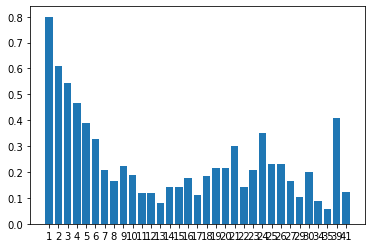

In [58]:
import matplotlib.pyplot as plt
word_count=sorted(list(dictionary.keys()))
error=[]
for i in word_count:
    error.append(dictionary[i])
plt.bar(range(len(dictionary)), error, tick_label=word_count)
plt.show()